In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [82]:
non_manual = pd.read_csv("experiments/data.csv")
manual = pd.read_csv("experiments/manual.csv")
df = pd.concat([non_manual, manual], ignore_index=True)
df.rename(columns={ "runtime_[s]": "runtime" }, inplace=True)
mask = (df.n_procs == 1) & (df.n_threads == 1) & (~df.full_command.str.contains("manual"))
t_seq = df[mask].runtime.mean()
df["speedup"] = t_seq / df.runtime
df["ram"] = df["peakRSS_[KiB]"] * 1024 / 10**6 # ram in GB
df.head()

,peakRSS_[KiB],runtime,n_procs,n_threads,n_sites,n_taxa,n_alignments,omp_alg,full_command,datetime_of_run,speedup,ram
0,262460,1037.268,1,1,6000,200000,48,IM,iqtree2 --alisim output/alg -m GTR+I{0.2}+G4{0...,Wed Sep 3 21:16:18 UTC 2025,1.001601,268.759040
1,530552,728.070,2,1,6000,200000,48,IM,mpirun -np 2 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:33:38 UTC 2025,1.426963,543.285248
2,1063400,368.202,4,1,6000,200000,48,IM,mpirun -np 4 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:45:50 UTC 2025,2.821627,1088.921600
3,2130072,212.496,8,1,6000,200000,48,IM,mpirun -np 8 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:52:01 UTC 2025,4.889168,2181.193728
4,3199756,185.473,12,1,6000,200000,48,IM,mpirun -np 12 --allow-run-as-root iqtree2-mpi ...,Wed Sep 3 21:55:37 UTC 2025,5.601509,3276.550144


In [83]:
upper = 200000
lower = 6000
assert ((df.n_sites == upper) | (df.n_sites == lower)).all()
assert ((df.n_taxa == upper) | (df.n_taxa == lower)).all()

In [90]:
df_mpi = df.iloc[:12]
df_omp_IM= df.iloc[12:24]
df_omp_EM = df.iloc[24:36]
df_hpc = df[df.full_command.str.contains("--bind-to none")]
df_manual = df[df.full_command.str.contains("manual")]

In [91]:
df

,peakRSS_[KiB],runtime,n_procs,n_threads,n_sites,n_taxa,n_alignments,omp_alg,full_command,datetime_of_run,speedup,ram
0,262460,1037.268,1,1,6000,200000,48,IM,iqtree2 --alisim output/alg -m GTR+I{0.2}+G4{0...,Wed Sep 3 21:16:18 UTC 2025,1.001601,268.759040
1,530552,728.070,2,1,6000,200000,48,IM,mpirun -np 2 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:33:38 UTC 2025,1.426963,543.285248
2,1063400,368.202,4,1,6000,200000,48,IM,mpirun -np 4 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:45:50 UTC 2025,2.821627,1088.921600
3,2130072,212.496,8,1,6000,200000,48,IM,mpirun -np 8 --allow-run-as-root iqtree2-mpi -...,Wed Sep 3 21:52:01 UTC 2025,4.889168,2181.193728
4,3199756,185.473,12,1,6000,200000,48,IM,mpirun -np 12 --allow-run-as-root iqtree2-mpi ...,Wed Sep 3 21:55:37 UTC 2025,5.601509,3276.550144
...,...,...,...,...,...,...,...,...,...,...,...,...
63,526252,515.823,2,1,6000,200000,48,IM,manual,Wed Sep 3 20:36:42 UTC 2025,2.014119,538.882048
64,1053804,263.915,4,1,6000,200000,48,IM,manual,Wed Sep 3 20:45:23 UTC 2025,3.936603,1079.095296
65,2108124,156.370,8,1,6000,200000,48,IM,manual,Wed Sep 3 20:49:51 UTC 2025,6.644041,2158.718976
66,3158484,144.665,12,1,6000,200000,48,IM,manual,Wed Sep 3 20:52:32 UTC 2025,7.181617,3234.287616


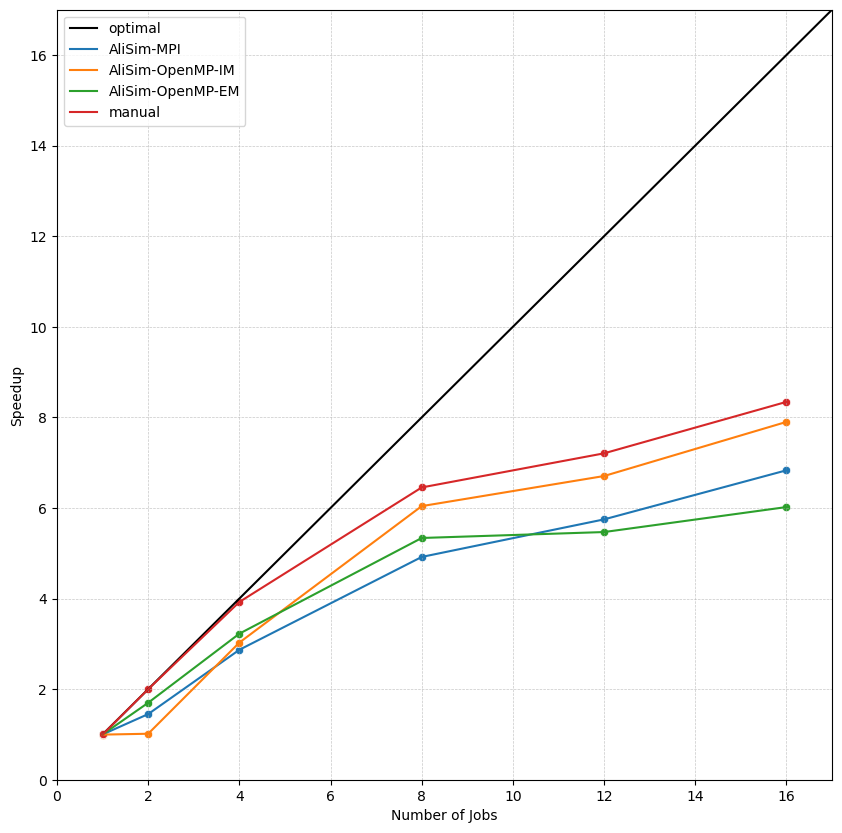

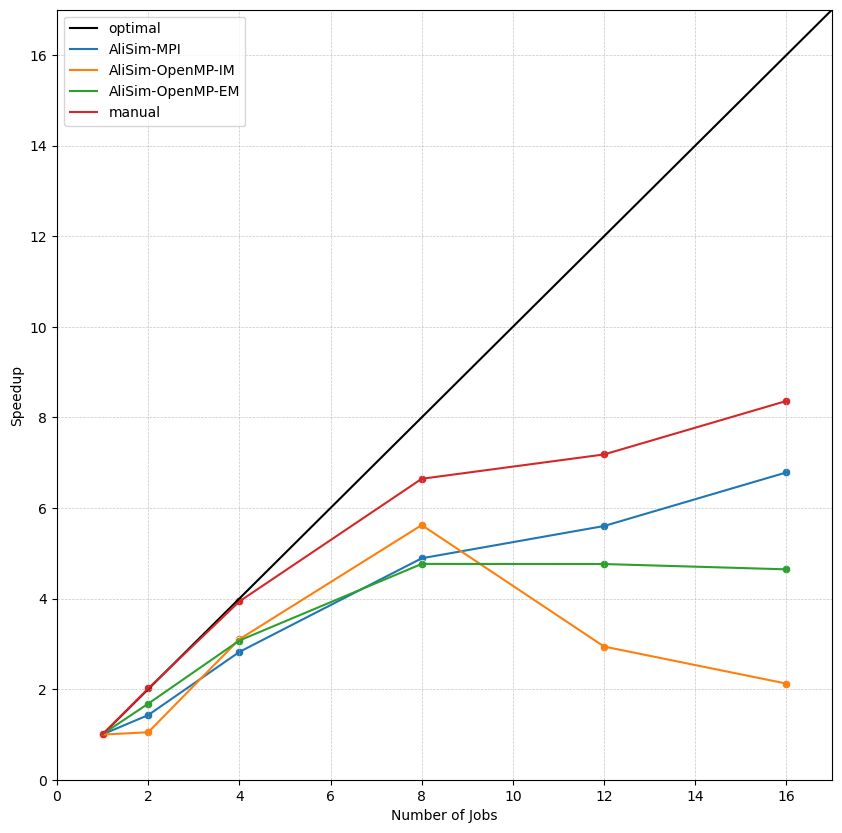

In [95]:
# figure 5
def speedup_plot(alg_type):
    if alg_type == 'long':
        mask_value = upper
    elif alg_type == 'deep':
        mask_value = lower
    else:
        raise ValueError('alg_type should be either "long" or "deep"')
    figure_size = (10, 10)
    fig = plt.figure(figsize=figure_size)
    
    # Customize axis limits (optional)
    margin = 1
    val_range = (0, 16+margin)
    plt.xlim(val_range)   # x-axis range
    plt.ylim(val_range)
    
    # Add labels and title
    plt.xlabel("Number of Jobs")
    plt.ylabel("Speedup")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)  # light grid
    
    sns.lineplot(x=[1, 16+margin], y=[1, 16+margin], label='optimal', color='black')

    y_field = 'speedup'
    for data, label, field in zip([df_mpi, df_omp_IM, df_omp_EM, df_manual],
                              ['AliSim-MPI', 'AliSim-OpenMP-IM', 'AliSim-OpenMP-EM', 'manual'],
                              ['n_procs', 'n_threads', 'n_threads', 'n_procs']):
        data_tmp = data[data.n_sites == mask_value]
        sns.lineplot(x=data_tmp[field], y=data_tmp[y_field], label=label)
        sns.scatterplot(x=data_tmp[field], y=data_tmp[y_field], label='_'+label)
    
    plt.legend()
    plt.show()

speedup_plot('long')
speedup_plot('deep')

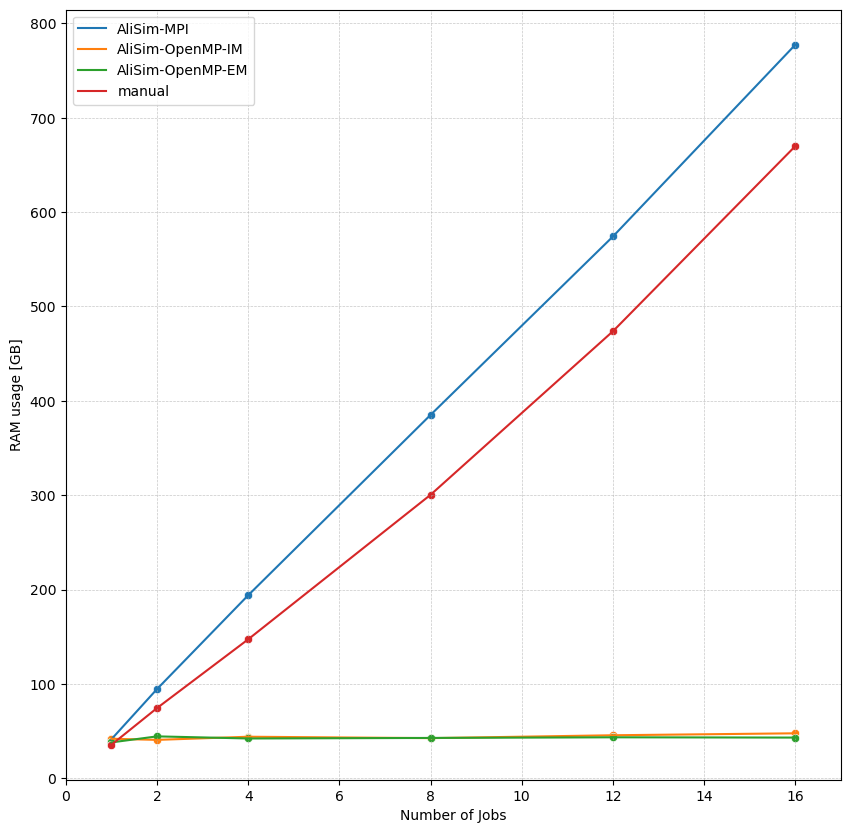

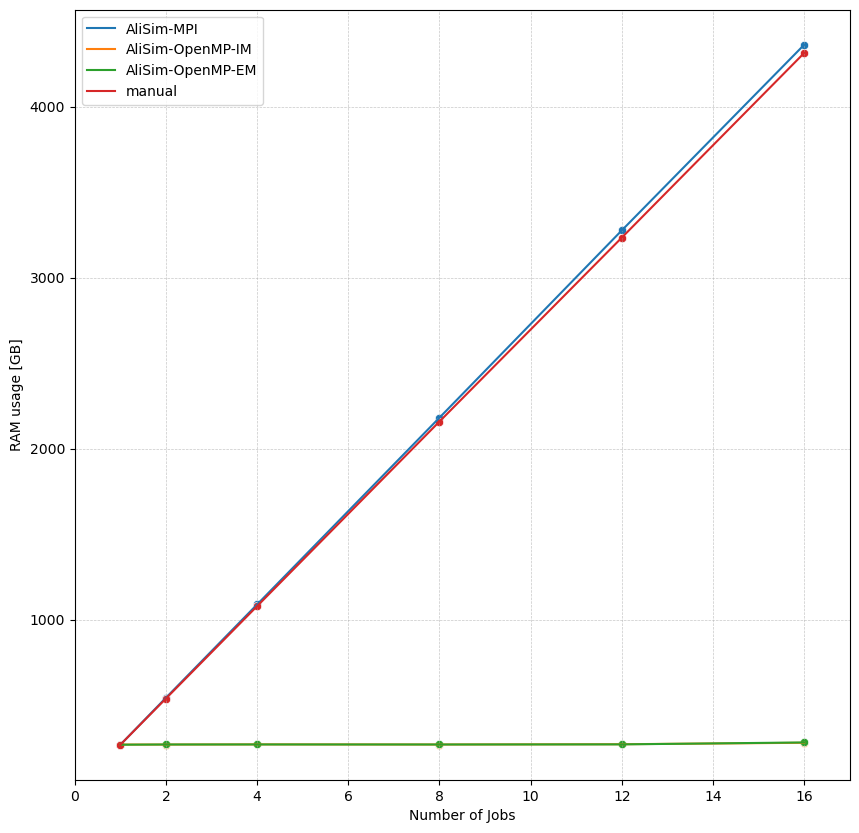

In [99]:
def ram_plot(alg_type):
    if alg_type == 'long':
        mask_value = upper
    elif alg_type == 'deep':
        mask_value = lower
    else:
        raise ValueError('alg_type should be either "long" or "deep"')
    figure_size = (10, 10)
    fig = plt.figure(figsize=figure_size)
    
    # Customize axis limits (optional)
    margin = 1
    val_range = (0, 16+margin)
    plt.xlim(val_range)   # x-axis range
    
    # Add labels and title
    plt.xlabel("Number of Jobs")
    plt.ylabel("RAM usage [GB]")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)  # light grid
    
    y_field = 'ram'
    for data, label, field in zip([df_mpi, df_omp_IM, df_omp_EM, df_manual],
                              ['AliSim-MPI', 'AliSim-OpenMP-IM', 'AliSim-OpenMP-EM', 'manual'],
                              ['n_procs', 'n_threads', 'n_threads', 'n_procs']):
        data_tmp = data[data.n_sites == mask_value]
        sns.lineplot(x=data_tmp[field], y=data_tmp[y_field], label=label)
        sns.scatterplot(x=data_tmp[field], y=data_tmp[y_field], label='_'+label)
    
    plt.legend()
    plt.show()

ram_plot('long')
ram_plot('deep')